# Pacoes e classes

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import tabela_equacoes
from funcoes.graficos import plotar_graficos
from funcoes.farenheit_celsius import trocar_temp
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt

In [23]:
df = pd.read_excel('C:/Users/joao.pinheiro/repos/tcc-serena/dados/tempeture_load.xlsx')
df.columns = ['interval_start_utc', 'interval_end_utc','publish_time_utc',
        'Unnamed', 'coast_carga', 'east_carga', 'far_west_carga', 'north_carga', 'north_central_carga',
        'south_central_carga', 'southern_carga', 'west_carga', 'sum_load', 'weekday', 'hour',
        'coast_tf', 'east_tf', 'far_west_tf', 'north_tf', 'north_central_tf',
        'south_central_tf', 'southern_tf', 'west_tf', 'avg_temp_fahrenheit']

df1 = df.copy()

In [24]:
colunas_fahrenheit = ['coast_tf',
                        'east_tf',
                        'far_west_tf',
                        'north_tf',
                        'north_central_tf',
                        'south_central_tf',
                        'southern_tf',
                        'west_tf',
                        'avg_temp_fahrenheit']

for col in colunas_fahrenheit:
    if col == 'avg_temp_fahrenheit':
        nova_col = 'avg_temp_celsius'
    else:
        nova_col = col.replace('_tf', '_tc')
    df1[nova_col] = (df1[col] - 32) * (5 / 9)

In [52]:
df1

,interval_start_utc,interval_end_utc,publish_time_utc,Unnamed,coast_carga,east_carga,far_west_carga,north_carga,north_central_carga,south_central_carga,...,avg_temp_fahrenheit,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc,avg_temp_celsius
0,2024-09-01 00:00:00,2024-09-01 01:00:00,2024-08-24 10:30:00,2024-08-24,18205.8008,2548.6599,7068.1699,2151.8401,21659.6992,12745.9004,...,92.68125,32.333333,33.333333,33.888889,33.611111,34.305556,35.000000,32.888889,34.333333,33.711806
1,2024-09-01 00:00:00,2024-09-01 01:00:00,2024-08-25 10:30:00,2024-08-25,18099.1992,2607.7300,6933.4702,2149.1799,21886.0996,12782.4004,...,92.01250,32.333333,33.611111,31.944444,33.888889,34.166667,34.444444,33.333333,33.000000,33.340278
2,2024-09-01 00:00:00,2024-09-01 01:00:00,2024-08-26 10:30:00,2024-08-26,18022.6992,2544.0000,6898.2700,2121.5701,21650.1992,12295.2002,...,90.39375,31.944444,33.333333,30.555556,32.222222,33.194444,33.611111,33.333333,31.333333,32.440972
3,2024-09-01 00:00:00,2024-09-01 01:00:00,2024-08-27 10:30:00,2024-08-27,16773.4004,2299.0701,6791.2202,2014.2800,19779.3008,11295.0000,...,86.86250,29.888889,28.611111,30.000000,29.722222,31.944444,31.111111,32.444444,30.111111,30.479167
4,2024-09-01 00:00:00,2024-09-01 01:00:00,2024-08-28 10:30:00,2024-08-28,16450.0000,2232.3701,6755.8999,1998.1700,18903.5000,11400.4004,...,85.98125,29.888889,28.611111,28.888889,29.444444,30.416667,31.111111,32.111111,29.444444,29.989583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22840,2023-11-11 18:00:00,2023-11-11 19:00:00,2023-11-05 10:30:00,2023-11-05,10909.7002,1494.8500,6119.1899,1160.5200,11335.0000,6648.5298,...,60.12500,19.444444,16.111111,9.722222,14.166667,15.000000,16.666667,21.222222,12.666667,15.625000
22841,2023-11-11 18:00:00,2023-11-11 19:00:00,2023-11-06 10:30:03,2023-11-06,10860.9004,1463.9800,6099.0200,1182.2300,11804.7998,6697.3398,...,61.06250,18.611111,16.388889,12.500000,14.722222,15.555556,16.944444,20.222222,14.222222,16.145833
22842,2023-11-11 18:00:00,2023-11-11 19:00:00,2023-11-07 10:30:00,2023-11-07,10922.7998,1508.1400,6117.7500,1199.6000,11783.2998,6944.8999,...,57.90625,17.555556,14.166667,10.833333,13.055556,13.472222,15.277778,18.000000,12.777778,14.392361
22843,2023-11-11 18:00:00,2023-11-11 19:00:00,2023-11-08 10:30:00,2023-11-08,11278.4004,1602.1700,6305.5098,1270.5000,12333.5000,7073.1001,...,56.25625,16.222222,12.500000,10.555556,12.777778,12.916667,13.611111,17.000000,12.222222,13.475694


In [ ]:
tabela_equacoes(df1)

,Hora,avg_temp_celsius,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc
0,0,y = 92.67x² + -3253.61x + 74901.67,y = 29.59x² + -1024.79x + 20721.17,y = 4.15x² + -152.20x + 3040.03,y = 1.31x² + -28.16x + 6098.99,y = 2.07x² + -61.44x + 1800.27,y = 30.49x² + -1071.98x + 22102.83,y = 17.28x² + -622.62x + 13302.62,y = 8.40x² + -296.36x + 6145.99,y = 2.20x² + -80.49x + 2017.53
1,1,y = 85.07x² + -2877.24x + 70876.13,y = 27.63x² + -913.58x + 19380.11,y = 3.70x² + -130.20x + 2798.51,y = 1.46x² + -39.05x + 6261.59,y = 1.90x² + -54.45x + 1738.30,y = 28.16x² + -960.95x + 20955.81,y = 16.11x² + -563.96x + 12673.89,y = 8.37x² + -295.44x + 6231.01,y = 2.00x² + -72.88x + 1963.95
2,2,y = 84.09x² + -2705.92x + 67709.95,y = 27.91x² + -894.48x + 18797.62,y = 3.73x² + -126.58x + 2692.38,y = 1.76x² + -45.77x + 6365.42,y = 1.90x² + -50.16x + 1667.56,y = 27.81x² + -911.67x + 20006.16,y = 16.12x² + -538.90x + 12080.02,y = 8.53x² + -292.97x + 6099.88,y = 2.00x² + -69.76x + 1890.48
3,3,y = 86.74x² + -2719.67x + 65950.80,y = 27.88x² + -879.69x + 18237.11,y = 3.97x² + -132.28x + 2643.13,y = 2.00x² + -53.69x + 6536.77,y = 1.98x² + -49.52x + 1610.15,y = 29.23x² + -943.18x + 19583.94,y = 16.97x² + -553.54x + 11782.10,y = 8.60x² + -291.82x + 5962.39,y = 2.05x² + -69.32x + 1822.92
4,4,y = 88.36x² + -2701.04x + 63233.85,y = 27.76x² + -862.45x + 17476.69,y = 4.11x² + -133.81x + 2529.30,y = 2.28x² + -61.26x + 6610.79,y = 2.04x² + -49.58x + 1544.78,y = 29.99x² + -950.95x + 18727.89,y = 17.48x² + -555.60x + 11263.78,y = 8.66x² + -290.83x + 5767.62,y = 2.08x² + -67.58x + 1718.43
5,5,y = 89.82x² + -2681.92x + 60555.08,y = 27.21x² + -829.41x + 16575.04,y = 4.26x² + -136.11x + 2435.35,y = 2.36x² + -61.48x + 6603.58,y = 2.08x² + -48.66x + 1477.11,y = 30.73x² + -955.24x + 17858.21,y = 18.02x² + -558.76x + 10747.75,y = 9.08x² + -304.63x + 5691.99,y = 2.18x² + -69.48x + 1654.91
6,6,y = 90.08x² + -2636.03x + 58162.98,y = 26.44x² + -795.65x + 15829.95,y = 4.27x² + -134.54x + 2341.53,y = 2.29x² + -54.76x + 6510.46,y = 2.13x² + -50.26x + 1457.49,y = 30.50x² + -929.82x + 16941.57,y = 18.02x² + -542.24x + 10135.31,y = 9.26x² + -307.11x + 5505.98,y = 2.16x² + -66.90x + 1586.03
7,7,y = 3.18x² + 349.80x + 36298.20,y = -3.71x² + 335.63x + 6275.74,y = 0.82x² + -24.66x + 1615.17,y = 0.40x² + 8.80x + 6102.91,y = 0.40x² + -0.56x + 1190.04,y = 6.44x² + -129.48x + 11498.97,y = 0.27x² + 77.01x + 5500.75,y = -1.64x² + 142.23x + 1143.87,y = 0.72x² + -20.77x + 1293.59
8,8,y = 91.19x² + -2560.63x + 55109.07,y = 26.29x² + -771.91x + 15084.51,y = 4.31x² + -132.34x + 2222.68,y = 2.30x² + -47.49x + 6376.47,y = 2.06x² + -47.33x + 1405.72,y = 30.79x² + -899.49x + 15837.15,y = 18.35x² + -529.75x + 9506.92,y = 9.66x² + -314.70x + 5325.29,y = 2.11x² + -62.69x + 1501.99
9,9,y = 92.43x² + -2542.51x + 54535.71,y = 26.43x² + -766.30x + 14968.14,y = 4.34x² + -131.06x + 2199.08,y = 2.28x² + -44.18x + 6346.42,y = 2.08x² + -47.25x + 1401.89,y = 31.35x² + -895.41x + 15638.41,y = 18.69x² + -532.17x + 9443.49,y = 9.69x² + -312.00x + 5248.24,y = 2.15x² + -62.44x + 1482.50


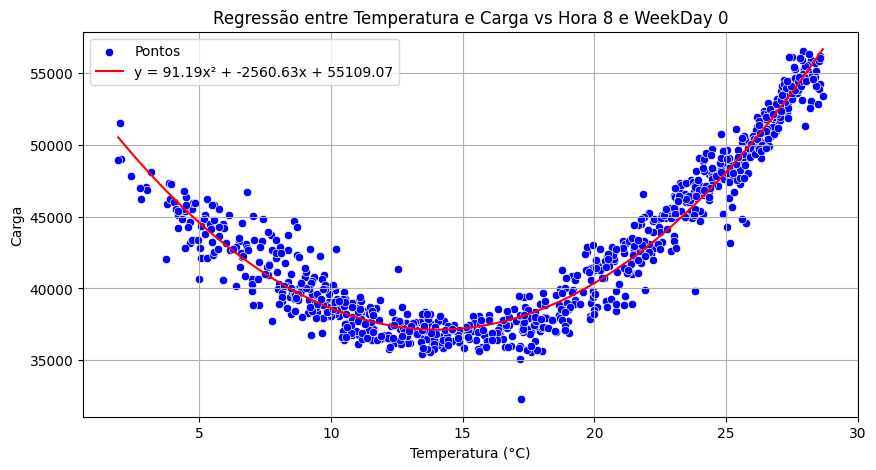

In [5]:
plotar_graficos(df = df1, hour= 8, weekday=0)

# Utilizando classes

In [6]:
# credencias
api_key = '41ac637ac7464f6da57351ed3fa5e5ff'
start_date = "2023-09-01"
end_date = "2024-09-01"

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!! aumentar horizonte de tempo

# # Temperatura
# temp = Temperature(api_key)
# df_temp = temp.get_df_temp(start_date, end_date)

# # Carga
# load = Load(api_key)
# df_load = load.get_df_load(start_date, end_date)


# df_temp.to_csv('df_temp.csv')
# df_load.to_csv('df_load.csv')

# Lendo arquivos baixados pela api
filtrar de 2023/09 até 2024/09 todas as horas da carga

In [45]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_load.csv')

In [46]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]


In [47]:
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


# hora_inicio = dt.time(5, 30)   # 05:30
# hora_fim = dt.time(0, 30)      # 00:30 (meia-noite e meia)

# # Filtra os dados entre 05:30 e 23:59 OU entre 00:00 e 00:30
# df = df[
#     (df['publish_time_utc_carga'].dt.time > hora_inicio) |
#     (df['publish_time_utc_carga'].dt.time <= hora_fim)
# ]

hora = dt.time(10, 30)  
df = df[(df['publish_time_utc_carga'].dt.time == hora)]




In [48]:
df

,interval_start_utc,interval_end_utc,publish_time_utc_carga,coast_carga,east_carga,far_west_carga,north_carga,north_central_carga,south_central_carga,southern_carga,...,avg_temp_fahrenheit,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc,avg_temp_celsius
5,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-24 10:30:00,15754.7002,2592.1499,6031.5200,1995.6801,24349.1992,12124.0000,5415.6201,...,94.98125,33.611111,33.333333,35.555556,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583
53,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-26 10:30:00,18833.6992,2536.3701,6121.2700,1964.8101,23720.3008,11504.2002,5688.4502,...,94.98125,33.611111,33.333333,35.555556,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583
101,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-28 10:30:00,18314.1992,2559.4700,6163.2202,1949.4399,23442.6992,13311.9004,5669.0898,...,94.98125,33.611111,33.333333,35.555556,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583
149,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-30 10:30:00,18665.6992,2535.8701,6106.0200,1941.1899,22746.0000,13618.9004,5630.3999,...,94.98125,33.611111,33.333333,35.555556,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583
197,2023-08-31 20:00:00,2023-09-01 02:00:00,2023-08-24 10:30:00,15446.0996,2471.0100,5940.2100,1921.5000,23334.5996,11676.4004,5266.2998,...,91.17500,31.722222,31.388889,34.444444,31.388889,33.055556,34.444444,31.666667,34.888889,32.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599707,2024-08-11 14:00:00,2024-08-11 20:00:00,2024-08-11 10:30:00,20145.1992,2714.1399,7260.4502,2276.4199,23126.4004,12883.7998,5930.7202,...,93.71875,33.555556,33.611111,35.833333,30.277778,34.861111,34.722222,34.444444,37.000000,34.288194
599731,2024-08-11 15:00:00,2024-08-11 21:00:00,2024-08-04 10:30:00,19577.5000,2706.1699,7154.2002,2140.5701,22955.5000,13817.0996,6045.8901,...,95.19375,34.666667,34.722222,36.388889,31.666667,35.138889,35.833333,34.888889,37.555556,35.107639
599755,2024-08-11 15:00:00,2024-08-11 21:00:00,2024-08-05 10:30:00,20697.9004,3008.9600,6997.1201,2392.7700,26291.0996,14681.2998,6004.8701,...,95.19375,34.666667,34.722222,36.388889,31.666667,35.138889,35.833333,34.888889,37.555556,35.107639
599779,2024-08-11 15:00:00,2024-08-11 21:00:00,2024-08-06 10:30:00,20320.6992,2940.1101,7137.2300,2288.4600,24780.6992,14103.0000,6088.8999,...,95.19375,34.666667,34.722222,36.388889,31.666667,35.138889,35.833333,34.888889,37.555556,35.107639


In [38]:
# esta dando nan pq tem muitos valores nulos em cargas
tabela_equacoes(df)

,Hora,avg_temp_celsius,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc
0,0,y = 91.31x² + -2471.87x + 55699.19,y = 26.28x² + -752.44x + 15234.01,y = 3.69x² + -106.90x + 2100.06,y = 2.22x² + -55.69x + 6477.99,y = 2.27x² + -50.61x + 1441.36,y = 29.31x² + -804.06x + 15603.09,y = 15.98x² + -416.04x + 8817.02,y = 9.29x² + -290.85x + 5213.97,y = 1.98x² + -54.40x + 1468.54
1,1,y = 1.49x² + 526.51x + 34738.07,y = -3.74x² + 356.69x + 6078.41,y = 0.51x² + -10.09x + 1504.17,y = 0.45x² + 3.45x + 6105.60,y = 0.34x² + 2.91x + 1170.09,y = 3.58x² + 24.79x + 10288.45,y = 0.44x² + 88.43x + 5468.49,y = -1.40x² + 131.62x + 1356.69,y = 0.74x² + -16.71x + 1256.28
2,2,y = 90.42x² + -2443.51x + 53429.54,y = 23.81x² + -674.52x + 14170.10,y = 3.60x² + -105.81x + 2020.87,y = 2.16x² + -47.00x + 6330.01,y = 2.20x² + -49.82x + 1390.64,y = 29.27x² + -804.87x + 14899.37,y = 15.83x² + -416.82x + 8428.67,y = 9.02x² + -280.91x + 4920.29,y = 2.04x² + -56.98x + 1449.49
3,3,y = 90.05x² + -2422.68x + 52922.41,y = 23.48x² + -665.79x + 14068.47,y = 3.53x² + -104.08x + 2001.34,y = 2.07x² + -43.90x + 6302.55,y = 2.14x² + -48.79x + 1389.71,y = 29.78x² + -815.87x + 14834.25,y = 15.54x² + -411.39x + 8370.91,y = 8.80x² + -272.79x + 4812.04,y = 2.06x² + -57.32x + 1432.98
4,4,y = 90.21x² + -2429.58x + 53324.01,y = 23.09x² + -656.02x + 14139.22,y = 3.54x² + -105.63x + 2038.64,y = 2.03x² + -40.79x + 6262.77,y = 2.13x² + -49.04x + 1403.08,y = 29.73x² + -814.49x + 14953.36,y = 14.99x² + -395.51x + 8330.48,y = 9.00x² + -284.77x + 4974.05,y = 2.06x² + -57.71x + 1449.10
5,5,y = 90.49x² + -2470.03x + 55255.77,y = 23.78x² + -692.67x + 14921.49,y = 3.55x² + -108.05x + 2135.40,y = 1.96x² + -40.28x + 6279.15,y = 2.02x² + -47.59x + 1450.26,y = 29.83x² + -829.97x + 15676.25,y = 14.57x² + -390.89x + 8621.97,y = 8.82x² + -283.01x + 5108.92,y = 1.98x² + -56.78x + 1491.96
6,6,y = 87.28x² + -2442.03x + 58093.60,y = 23.16x² + -691.36x + 15630.38,y = 3.34x² + -105.36x + 2268.22,y = 1.70x² + -35.07x + 6327.07,y = 1.99x² + -48.68x + 1541.40,y = 27.98x² + -797.43x + 16586.01,y = 14.37x² + -405.27x + 9366.31,y = 8.41x² + -277.52x + 5372.00,y = 1.80x² + -54.30x + 1568.00
7,7,y = 84.74x² + -2393.47x + 59396.65,y = 24.39x² + -741.62x + 16357.28,y = 3.23x² + -103.21x + 2323.08,y = 1.51x² + -30.44x + 6334.11,y = 1.90x² + -48.19x + 1593.57,y = 27.24x² + -789.36x + 17194.83,y = 13.21x² + -377.91x + 9550.90,y = 8.54x² + -285.70x + 5566.90,y = 1.70x² + -52.57x + 1616.66
8,8,y = 84.66x² + -2385.76x + 59984.04,y = 24.96x² + -767.58x + 16818.92,y = 3.25x² + -102.46x + 2333.22,y = 2.29x² + -51.77x + 6498.99,y = 1.89x² + -47.20x + 1602.43,y = 26.79x² + -771.42x + 17289.70,y = 15.08x² + -438.81x + 10030.90,y = 8.94x² + -301.87x + 5727.55,y = 1.65x² + -48.09x + 1596.95
9,9,y = 89.58x² + -2678.39x + 64153.84,y = 25.47x² + -812.89x + 17734.11,y = 3.66x² + -120.50x + 2543.22,y = 2.36x² + -58.15x + 6646.12,y = 1.99x² + -53.33x + 1680.32,y = 28.46x² + -858.80x + 18522.79,y = 18.81x² + -599.88x + 11692.99,y = 9.20x² + -325.68x + 6148.49,y = 1.77x² + -52.14x + 1658.31


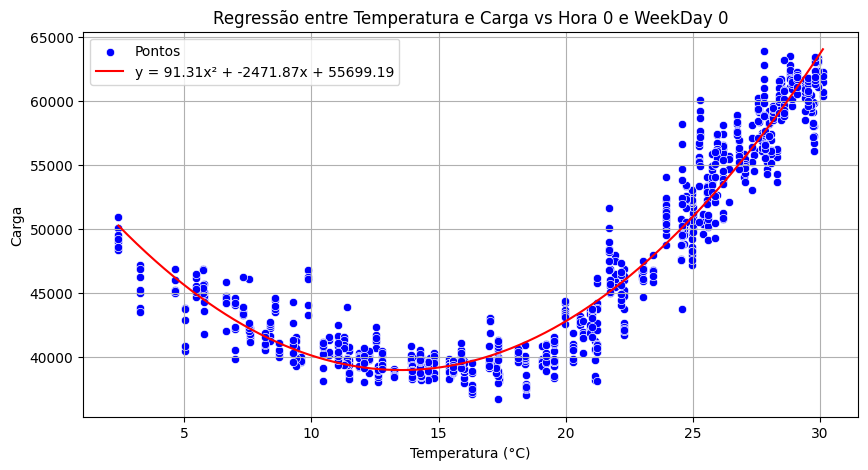

In [39]:
plotar_graficos(df= df , weekday= 0, hour= 0)